<a href="https://colab.research.google.com/github/ssoufiene/CoSeDif/blob/main/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install beartype

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.6 MB/s eta 0:00:00


In [1]:
!git clone https://github.com/ssoufiene/CoSeDif.git

Cloning into 'CoSeDif'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 270.96 KiB | 7.32 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
%cd  /content/CoSeDif

/content/CoSeDif


In [13]:
!gdown --folder "https://drive.google.com/drive/folders/1BRdqWstPYx36QwaixMji-SDAIoskrHJi?usp=drive_link" -O ./downloaded_folder

Retrieving folder contents
Retrieving folder 1ikQSfUJKfldOHmyvIDDGpMNt92BogNKd condition
Processing file 187zdoPuf_dumLqoBISUMn4wNh6hx6JoH 0.npy
Processing file 1GUmaL_mJaeRgaAAIHelTYrdnTXrFtVVr 1.npy
Processing file 1z4Dzv5-t4cXm4UgfE2UXT-uRE807TeQr 2.npy
Processing file 1tPuJ_sEZZq7mdKanXwOp6PyTWgF_pIr_ 3.npy
Processing file 16Qin9j6vdv01Z0UGDnvvxpa2D0lrdd-m 4.npy
Processing file 1td8voSt015YjhhQe4DQGOZF30j7VC3s- 5.npy
Processing file 1P4M-F8X8Bw05a9N7ZVPwsOkY5OE7aWaC 6.npy
Processing file 1IteMai1E1_JMST025ym7y0w9hdCuegXB 7.npy
Processing file 1GHOr-ucj9-JR675RbTumblpGFeDxitC6 8.npy
Processing file 1kt5GTrssGMFuHMmXtbUkkmRykDOCP21Y 9.npy
Processing file 1wPSiMlWM70xjidnmBm-Ijp-Kh4tYNJmf 10.npy
Retrieving folder 1xYBTI_E4WZtJt68bFjYU6RHdf-dEKry2 original
Processing file 1s3W1kfkPm1gPc2CkEU70AzJbcUF5vJaM 0.npy
Processing file 15yAb_94EPHIuFlh2fMtIGL2RPZhyyaBo 1.npy
Processing file 1J2sfHfStHsfgmWq2ZWGHeU03M_z7xhTS 2.npy
Processing file 1p75AijMPmN_ohANrH_J1T_YLbOkGuM7T 3.npy
Processin

In [28]:
import os
import argparse
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
from model.cosedif import Unet, CoSeDif
import skimage.io as io
from accelerate import Accelerator
from PIL import Image


## Parse CLI arguments ##
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('-od', '--output_dir', type=str, default="output", help="Output dir.")
    parser.add_argument('-ld', '--logging_dir', type=str, default="logs", help="Logging dir.")
    parser.add_argument('-mp', '--mixed_precision', type=str, default="bf16", choices=["no", "fp16", "bf16"],
                        help="Whether to do mixed precision")


    parser.add_argument('-ic', '--mask_channels', type=int, default=1, help='input channels for training (default: 3)')
    parser.add_argument('-c', '--input_img_channels', type=int, default=1,
                        help='output channels for training (default: 3)')
    parser.add_argument('-is', '--image_size', type=int, default=128, help='input image size (default: 128)')
    parser.add_argument('-d', '--dim', type=int, default=64, help='dim (default: 64)')
    parser.add_argument('-e', '--epochs', type=int, default=10000, help='number of epochs (default: 10000)')
    parser.add_argument('-bs', '--batch_size', type=int, default=8, help='batch size to train on (default: 8)')
    parser.add_argument('--timesteps', type=int, default=1000, help='number of timesteps (default: 1000)')
    parser.add_argument('-ds', '--dataset', default='seismic', help='Dataset to use')
    args, unknown = parser.parse_known_args()

    return args

In [33]:
args = parse_args()
logging_dir = os.path.join(args.output_dir, args.logging_dir)
inference_dir = os.path.join(args.output_dir, 'inference')
os.makedirs(inference_dir, exist_ok=True)
accelerator = Accelerator(mixed_precision=args.mixed_precision,)
## DEFINE MODEL ##
model = Unet(
    dim=args.dim,
    image_size=args.image_size,
    dim_mults=(1, 2, 4, 8),
    mask_channels=args.mask_channels,
    input_img_channels=args.input_img_channels,
)



diffusion = CoSeDif(
    model,
    timesteps=args.timesteps,
    sampling_timesteps=100
).to(accelerator.device)

save_dict=torch.load(r"/content/CoSeDif/downloaded_folder/FaultDiff.pt")
diffusion.model.load_state_dict(save_dict['model_state_dict'])
print('model_loaded')






<ipython-input-33-ca5dc7b1b620>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict=torch.load(r"/content/CoSeDif/downloaded_folder/FaultDiff.pt")


model_loaded


Edges shape: (1, 128, 128)
Image shape: (1, 128, 128)


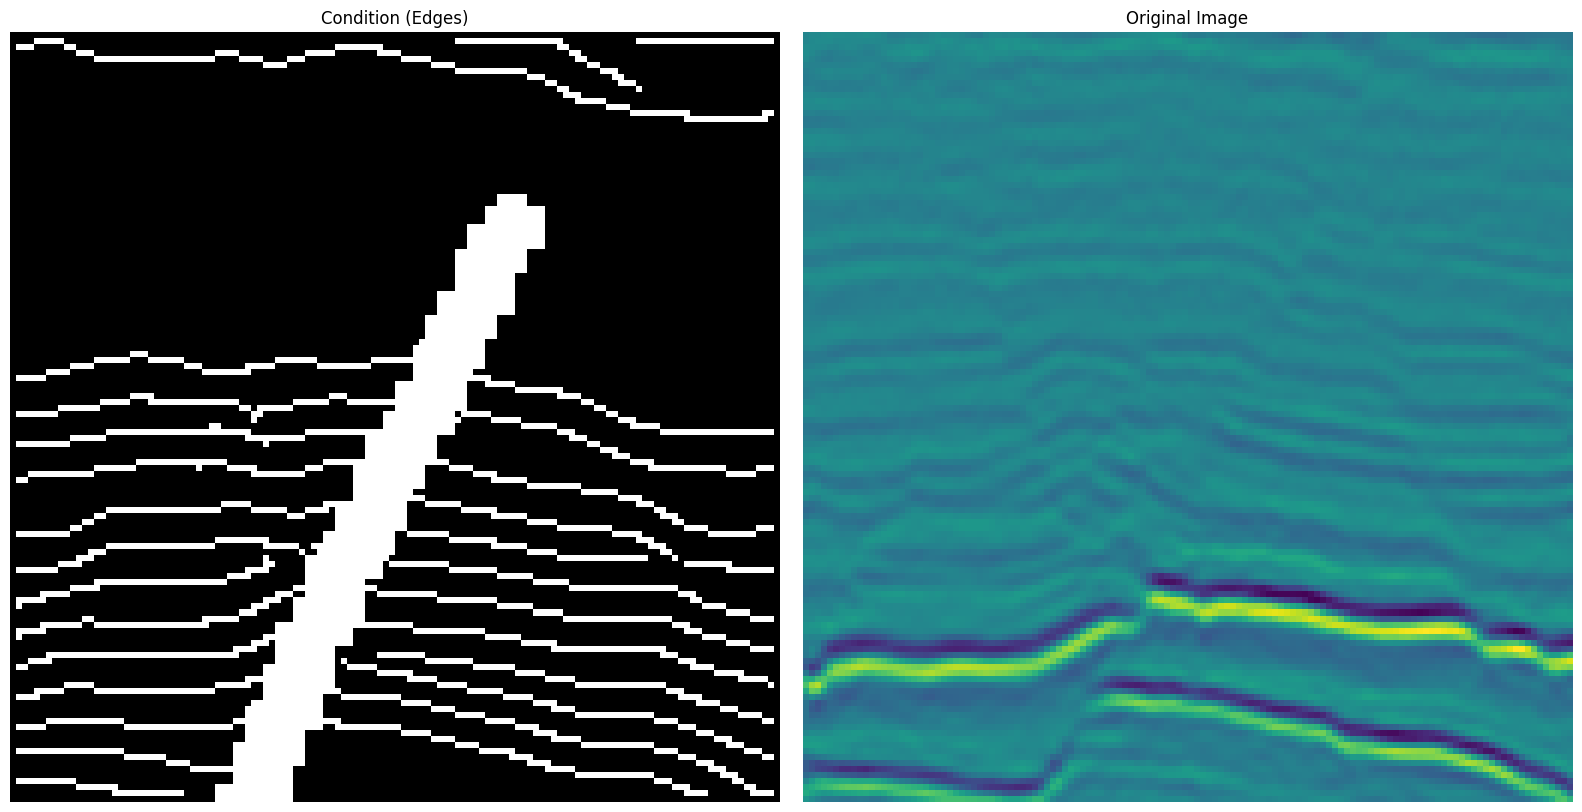

In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load the condition (edges) and original image
edges = np.load(r'/content/CoSeDif/downloaded_folder/condition/10.npy')
image = np.load(r'/content/CoSeDif/downloaded_folder/original/10.npy')

# Print shapes to verify
print("Edges shape:", edges.shape)
print("Image shape:", image.shape)

# Create a figure with two subplots side by side
plt.figure(figsize=(16, 8))

# Plot the edges (condition)
plt.subplot(1, 2, 1)
plt.imshow(edges[0], cmap='gray')
plt.title('Condition (Edges)')
plt.axis('off')

# Plot the original image
plt.subplot(1, 2, 2)
plt.imshow(image[0], cmap='viridis')
plt.title('Original Image')
plt.axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [43]:
edges=np.expand_dims(edges, axis=0)
edges = torch.tensor(edges, dtype=torch.float32)

print(edges.shape)
print(edges.dtype)

torch.Size([1, 1, 128, 128])
torch.float32


In [44]:
pred=diffusion.sample(edges).cpu().detach()


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

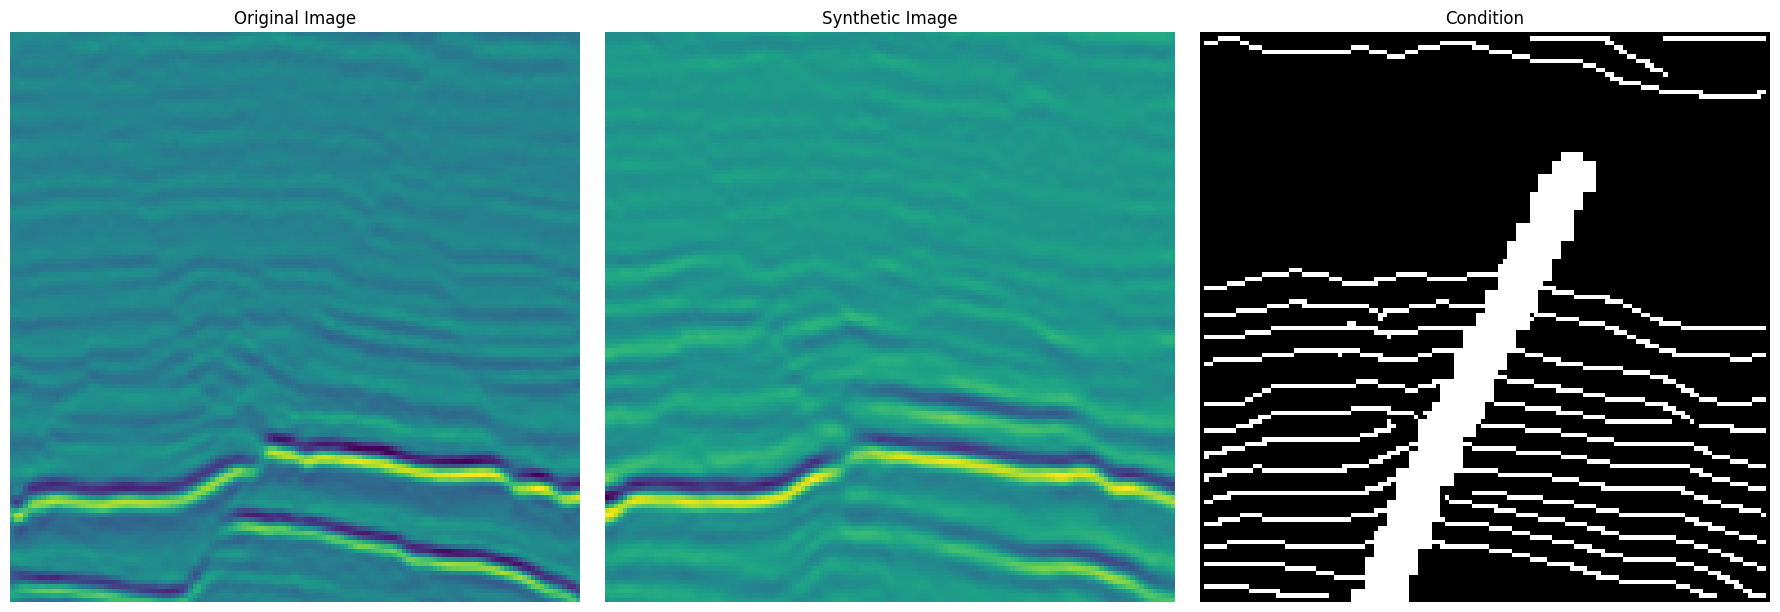

In [45]:


# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the original image
axes[0].imshow(image[0])
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the synthetic image
axes[1].imshow(pred[0][0])
axes[1].set_title('Synthetic Image')
axes[1].axis('off')

# Plot the condition (edges)
axes[2].imshow(edges[0][0],cmap='gray')
axes[2].set_title('Condition')
axes[2].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [46]:
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio
from sklearn.metrics import mean_squared_error

# Convert images to numpy arrays (assuming pred[0][0] and image[0] are numpy arrays)
synthetic_image = np.array(pred[0][0])
real_image = np.array(image[0])

def calculate_dssim(img1, img2):
    """Calculate Structural Dissimilarity Index."""
    ssim_value = ssim(img1, img2, data_range=1, multichannel=True)
    dssim = (1 - ssim_value) / 2
    return dssim

# Calculate MSE using sklearn
mse = mean_squared_error(real_image.flatten(), synthetic_image.flatten())

# Calculate PSNR using skimage
psnr_value = peak_signal_noise_ratio(real_image, synthetic_image, data_range=1)

# Calculate DSSIM
dssim_value = calculate_dssim(real_image, synthetic_image)

print(f"Peak Signal-to-Noise Ratio: {psnr_value:.2f} dB")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Structural Dissimilarity Index: {dssim_value:.4f}")


Peak Signal-to-Noise Ratio: 21.91 dB
Mean Squared Error: 0.0064
Structural Dissimilarity Index: 0.1648
